<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-5/blob/main/ColoreadoTerritorio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Coloreado de imagenes aereas del territorio Riojano

Para comenzar con el trabajo, vamos a descargar el dataset de las imagenes de territorio.

In [20]:
!wget https://www.dropbox.com/s/8zr9fpfbth917oj/ImagenesTerritorio.zip?dl=0 -O FotosTerritorio.zip

--2021-05-23 11:06:28--  https://www.dropbox.com/s/8zr9fpfbth917oj/ImagenesTerritorio.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/8zr9fpfbth917oj/ImagenesTerritorio.zip [following]
--2021-05-23 11:06:28--  https://www.dropbox.com/s/raw/8zr9fpfbth917oj/ImagenesTerritorio.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce5f4f39c226a2696b26f4d8c51.dl.dropboxusercontent.com/cd/0/inline/BPAWwqYTz5QW3eDv1oQa_rGGbA7VYuBG2ZV0pEvF11EmR-3tngDbq3demCn6hY1qYThQUKWf1lQ_7jYWgsUCqPR3N7ty-16a1NVUXHoVjQ6tvy46u17ykmj8ke1VwEQz1I2-1Jm5gK0nJ_fl1ScvJ_FF/file# [following]
--2021-05-23 11:06:28--  https://uce5f4f39c226a2696b26f4d8c51.dl.dropboxusercontent.com/cd/0/inline/BPAWwqYTz5QW3eDv1oQa_rGGbA7VYuBG2ZV0pEvF11EmR-3tngDbq3d

In [21]:
!unzip FotosTerritorio.zip

Archive:  FotosTerritorio.zip
  inflating: data/1977/162070.jpg    
  inflating: data/1977/162071.jpg    
  inflating: data/1977/162078.jpg    
  inflating: data/1977/162080.jpg    
  inflating: data/1977/162081.jpg    
  inflating: data/1977/162082.jpg    
  inflating: data/1977/162086.jpg    
  inflating: data/1977/162087.jpg    
  inflating: data/1977/162088.jpg    
  inflating: data/1977/163066.jpg    
  inflating: data/1977/163067.jpg    
  inflating: data/1977/163068.jpg    
  inflating: data/1977/163069.jpg    
  inflating: data/1977/163070.jpg    
  inflating: data/1977/163071.jpg    
  inflating: data/1977/163072.jpg    
  inflating: data/1977/163073.jpg    
  inflating: data/1977/163074.jpg    
  inflating: data/1977/163076.jpg    
  inflating: data/1977/163077.jpg    
  inflating: data/1977/163078.jpg    
  inflating: data/1977/163079.jpg    
  inflating: data/1977/163080.jpg    
  inflating: data/1977/163081.jpg    
  inflating: data/1977/163082.jpg    
  inflating: data/19

In [7]:
!pip install fastai --upgrade

     |████████████████████████████████| 204kB 6.7MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [58]:
from fastai.vision.all import *
from fastai.vision.gan import *
import cv2
from google.colab import files
import os

In [23]:
path = Path('data')

Usamos esta clase para transformar a escala de grises las imagenes a color de 2014

In [44]:
class Grisear():
  "Quickly draw tesxt and numbers on an image"
  def __init__(self, path_lr, path_hr):
      self.path_lr = path_lr
      self.path_hr = path_hr              
      
  def __call__(self, fn):       
      dest = self.path_lr/fn.relative_to(self.path_hr)    
      dest.parent.mkdir(parents=True, exist_ok=True)
      img = Image.open(fn)
      img = cv2.cvtColor(np.float32(img),cv2.COLOR_BGR2GRAY)
      cv2.imwrite(str(dest),img)

In [25]:
path_hr = path/'2014'
path_lr = path/'2014_G'

In [27]:
items = get_image_files(path_hr)

In [45]:
parallel(Grisear(path_lr, path_hr), items);

Creamos el DataBlock

In [46]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y = lambda x: path_hr/x.name,
                   splitter=RandomSplitter(),
                   item_tfms=Resize(224),
                   batch_tfms=[*aug_transforms(max_zoom=2.),
                               Normalize.from_stats(*imagenet_stats)])

In [52]:
dls = dblock.dataloaders(path_lr)

In [64]:
dls.c = 1

Mostramos el DataBlock

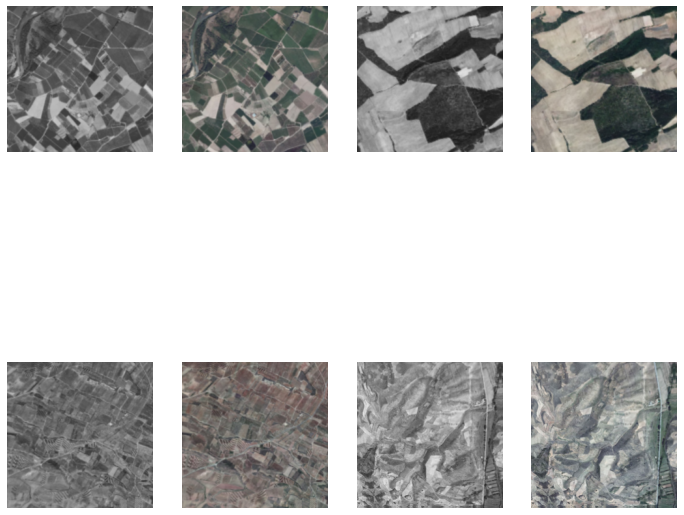

In [54]:
dls.show_batch(max_n=4, figsize=(12,12))

Como empiezan en walkwithfastai con ResNet34 es por donde empezaremos nosotros también.

In [55]:
wd, y_range, loss_gen = 1e-3, (-3., 3.), MSELossFlat()

In [67]:
learn = unet_learner(dls, models.resnet34, loss_func=loss_gen, y_range=y_range)

In [70]:
learn.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time


RuntimeError: ignored